In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


## DATA

In [4]:
title = "LQ down 1800 GeV"

In [5]:
##############
# input data #
##############

# b1,b2 -> (pT, eta, phi) from the leading and second b-tagged jets
# tau -> (pT, eta, phi) from the tau
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets, num_btag)  HT: sum PT of all the jets, number of jets (b-tag or not), number of b-tagged jets


################
# New Physics: #
################

datFolderNP = '../DATA/signal/dats-LQdown-1800GeV/'
k_LQdown = 1.8247261601649074
crossfidNP = 0.00105946448*k_LQdown

b1_NP = np.loadtxt(datFolderNP + 'b1.dat', delimiter=' ')
b2_NP = np.loadtxt(datFolderNP + 'b2.dat', delimiter=' ')
tau_NP = np.loadtxt(datFolderNP + 'tau.dat', delimiter=' ')
MET_NP = np.loadtxt(datFolderNP + 'MET.dat', delimiter=' ')
hadinfo_NP = np.loadtxt(datFolderNP + 'hadinfo.dat', delimiter=' ')

print('# eventos LQ: ', len(b1_NP))



###############
# Background: #
###############

# tt and fakett

datFolderSM_tt = '../DATA/background/dats-tt/'

k_fakett = 1.1053030485310749
crossfid_fakett = 0.19136
k_tt = 1.2593273872014419
crossfid_tt = (5.1373984*k_tt) + (crossfid_fakett * k_fakett)

b1_SM_tt = np.loadtxt(datFolderSM_tt + 'b1.dat', delimiter=' ')
b2_SM_tt = np.loadtxt(datFolderSM_tt + 'b2.dat', delimiter=' ')
tau_SM_tt = np.loadtxt(datFolderSM_tt + 'tau.dat', delimiter=' ')
MET_SM_tt = np.loadtxt(datFolderSM_tt + 'MET.dat', delimiter=' ')
hadinfo_SM_tt = np.loadtxt(datFolderSM_tt + 'hadinfo.dat', delimiter=' ')

print('# eventos tt: ', len(b1_SM_tt))


# singlet part 1

datFolderSM_singletP1 = '../DATA/background/dats-singletP1/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP1 = 0.39648*k_singletTOTAL

b1_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b1.dat', delimiter=' ')
b2_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b2.dat', delimiter=' ')
tau_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'tau.dat', delimiter=' ')
MET_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 1: ', len(b1_SM_singletP1))


# singlet part 2

datFolderSM_singletP2 = '../DATA/background/dats-singlet-comp/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP2 = 0.283008*k_singletTOTAL

b1_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b1.dat', delimiter=' ')
b2_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b2.dat', delimiter=' ')
tau_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'tau.dat', delimiter=' ')
MET_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 2: ', len(b1_SM_singletP2))


# Wbbjets

datFolderSM_Wbbjets = '../DATA/background/dats-Wbbjets/'
k_wjets = 0.9781509289273502
crossfid_Wbbjets = 0.9988452079186325*k_wjets

b1_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b1.dat', delimiter=' ')
b2_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b2.dat', delimiter=' ')
tau_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'tau.dat', delimiter=' ')
MET_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'MET.dat', delimiter=' ')
hadinfo_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'hadinfo.dat', delimiter=' ')

print('# eventos Wbbjets: ', len(b1_SM_Wbbjets))


# ttW (part of ttV)

datFolderSM_ttW = '../DATA/background/dats-ttW/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttW = 0.0231785208*k_ttV

b1_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b1.dat', delimiter=' ')
b2_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b2.dat', delimiter=' ')
tau_SM_ttW = np.loadtxt(datFolderSM_ttW + 'tau.dat', delimiter=' ')
MET_SM_ttW = np.loadtxt(datFolderSM_ttW + 'MET.dat', delimiter=' ')
hadinfo_SM_ttW = np.loadtxt(datFolderSM_ttW + 'hadinfo.dat', delimiter=' ')

print('# eventos ttW: ', len(b1_SM_ttW))


# ttZ

datFolderSM_ttZ = '../DATA/background/dats-ttZ/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttZ = 0.050087088*k_ttV

b1_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b1.dat', delimiter=' ')
b2_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b2.dat', delimiter=' ')
tau_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'tau.dat', delimiter=' ')
MET_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'MET.dat', delimiter=' ')
hadinfo_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'hadinfo.dat', delimiter=' ')

print('# eventos ttZ: ', len(b1_SM_ttZ))


# ttH

datFolderSM_ttH = '../DATA/background/dats-ttH/'
k_ttH = 2.2127445612386474
crossfid_ttH = 0.025004896*k_ttH

b1_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b1.dat', delimiter=' ')
b2_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b2.dat', delimiter=' ')
tau_SM_ttH = np.loadtxt(datFolderSM_ttH + 'tau.dat', delimiter=' ')
MET_SM_ttH = np.loadtxt(datFolderSM_ttH + 'MET.dat', delimiter=' ')
hadinfo_SM_ttH = np.loadtxt(datFolderSM_ttH + 'hadinfo.dat', delimiter=' ')

print('# eventos ttH: ', len(b1_SM_ttH))

# eventos LQ:  418625
# eventos tt:  826022
# eventos singlet part 1:  179677
# eventos singlet part 2:  94219
# eventos Wbbjets:  162448
# eventos ttW:  141919
# eventos ttZ:  16178
# eventos ttH:  12068


In [6]:
# Number of data points (per-class) for the ML classifier
num_data_NP = int(len(b1_NP)-1)
print(' SIGNAL ')
print('# S chosen: ', num_data_NP)



totalcrossSM = crossfid_tt + crossfid_singletP1+crossfid_singletP2 + crossfid_Wbbjets + crossfid_ttW+crossfid_ttZ + crossfid_ttH

num_data_SM_singletP1 = round( num_data_NP * (crossfid_singletP1/totalcrossSM) )
num_data_SM_singletP2 = round( num_data_NP * (crossfid_singletP2/totalcrossSM) )
num_data_SM_Wbbjets = round( num_data_NP * (crossfid_Wbbjets/totalcrossSM) )
num_data_SM_ttW = round( num_data_NP * (crossfid_ttW/totalcrossSM) )
num_data_SM_ttZ = round( num_data_NP * (crossfid_ttZ/totalcrossSM) )
num_data_SM_ttH = round( num_data_NP * (crossfid_ttH/totalcrossSM) )

num_data_SM_tt = num_data_NP - (num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ + num_data_SM_ttH)

num_data_SM = num_data_SM_tt + num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ +  num_data_SM_ttH


print('\n BACKGROUND ')
print('# tt chosen: ', num_data_SM_tt)
print('# singletP1 chosen: ', num_data_SM_singletP1)
print('# singletP2 chosen: ', num_data_SM_singletP2)
print('# Wbbjets chosen: ', num_data_SM_Wbbjets)
print('# ttW chosen: ', num_data_SM_ttW)
print('# ttZ chosen: ', num_data_SM_ttZ)
print('# ttH chosen: ', num_data_SM_ttH)

print('\n# total B eventos chosen: ', num_data_SM)



# CHECK IF THE NUMBER OF EVENTS ARE CORRECT
if num_data_SM == num_data_NP and num_data_NP < len(b1_NP) and num_data_SM_tt < len(b1_SM_tt) and num_data_SM_singletP1 < len(b1_SM_singletP1) and num_data_SM_singletP2 < len(b1_SM_singletP2) and num_data_SM_Wbbjets < len(b1_SM_Wbbjets) and num_data_SM_ttW < len(b1_SM_ttW) and num_data_SM_ttZ < len(b1_SM_ttZ) and num_data_SM_ttH < len(b1_SM_ttH):
    print( '\nEverything OK, continue')
else:
    print( '\nThe number of events of each channel not enought, check if you need to generate more')

 SIGNAL 
# S chosen:  418624

 BACKGROUND 
# tt chosen:  272195
# singletP1 chosen:  55577
# singletP2 chosen:  39671
# Wbbjets chosen:  39804
# ttW chosen:  2886
# ttZ chosen:  6237
# ttH chosen:  2254

# total B eventos chosen:  418624

Everything OK, continue


In [7]:
# KEEP ONLY THE NUMBER OF SIGNAL EVENTS THAT WE WILL USE
b1_NP = b1_NP[:num_data_NP]
b2_NP = b2_NP[:num_data_NP]
tau_NP = tau_NP[:num_data_NP]
MET_NP = MET_NP[:num_data_NP]
hadinfo_NP = hadinfo_NP[:num_data_NP]


# CONCATENATE YOUR SELECTED BACKGROUNDS (as many as you want, with the correct proportion)

b1_SM = np.concatenate((b1_SM_tt[:num_data_SM_tt],b1_SM_singletP1[:num_data_SM_singletP1],b1_SM_singletP2[:num_data_SM_singletP2],b1_SM_Wbbjets[:num_data_SM_Wbbjets],b1_SM_ttW[:num_data_SM_ttW],b1_SM_ttZ[:num_data_SM_ttZ],b1_SM_ttH[:num_data_SM_ttH]))
b2_SM = np.concatenate((b2_SM_tt[:num_data_SM_tt],b2_SM_singletP1[:num_data_SM_singletP1],b2_SM_singletP2[:num_data_SM_singletP2],b2_SM_Wbbjets[:num_data_SM_Wbbjets],b2_SM_ttW[:num_data_SM_ttW],b2_SM_ttZ[:num_data_SM_ttZ],b2_SM_ttH[:num_data_SM_ttH]))
tau_SM = np.concatenate((tau_SM_tt[:num_data_SM_tt],tau_SM_singletP1[:num_data_SM_singletP1],tau_SM_singletP2[:num_data_SM_singletP2],tau_SM_Wbbjets[:num_data_SM_Wbbjets],tau_SM_ttW[:num_data_SM_ttW],tau_SM_ttZ[:num_data_SM_ttZ],tau_SM_ttH[:num_data_SM_ttH]))
MET_SM = np.concatenate((MET_SM_tt[:num_data_SM_tt],MET_SM_singletP1[:num_data_SM_singletP1],MET_SM_singletP2[:num_data_SM_singletP2],MET_SM_Wbbjets[:num_data_SM_Wbbjets],MET_SM_ttW[:num_data_SM_ttW],MET_SM_ttZ[:num_data_SM_ttZ],MET_SM_ttH[:num_data_SM_ttH]))
hadinfo_SM = np.concatenate((hadinfo_SM_tt[:num_data_SM_tt],hadinfo_SM_singletP1[:num_data_SM_singletP1],hadinfo_SM_singletP2[:num_data_SM_singletP2],hadinfo_SM_Wbbjets[:num_data_SM_Wbbjets],hadinfo_SM_ttW[:num_data_SM_ttW],hadinfo_SM_ttZ[:num_data_SM_ttZ],hadinfo_SM_ttH[:num_data_SM_ttH]))

del b1_SM_tt
del b2_SM_tt
del tau_SM_tt
del MET_SM_tt
del hadinfo_SM_tt

del b1_SM_singletP1
del b2_SM_singletP1
del tau_SM_singletP1
del MET_SM_singletP1
del hadinfo_SM_singletP1

del b1_SM_singletP2
del b2_SM_singletP2
del tau_SM_singletP2
del MET_SM_singletP2
del hadinfo_SM_singletP2

del b1_SM_Wbbjets
del b2_SM_Wbbjets
del tau_SM_Wbbjets
del MET_SM_Wbbjets
del hadinfo_SM_Wbbjets

del b1_SM_ttW
del b2_SM_ttW
del tau_SM_ttW
del MET_SM_ttW
del hadinfo_SM_ttW

del b1_SM_ttZ
del b2_SM_ttZ
del tau_SM_ttZ
del MET_SM_ttZ
del hadinfo_SM_ttZ

del b1_SM_ttH
del b2_SM_ttH
del tau_SM_ttH
del MET_SM_ttH
del hadinfo_SM_ttH

In [8]:
print('# Background events: ', len(b1_SM))
print('# Signal events: ', len(b1_NP))

# Background events:  418624
# Signal events:  418624


### pdfs

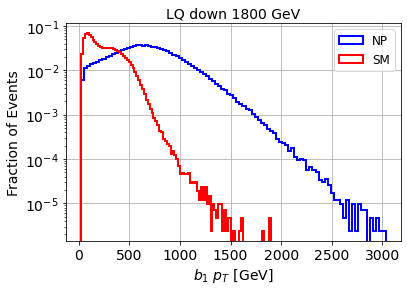

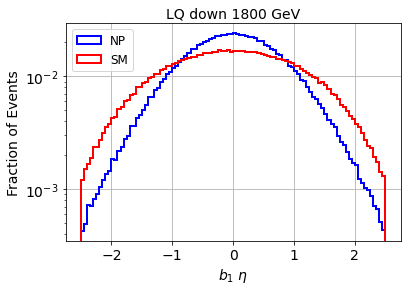

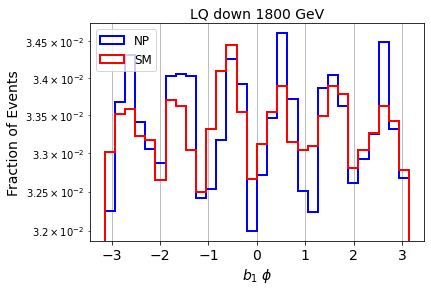

In [9]:
weights = np.ones_like(b1_NP[:,0])/float(len(b1_NP[:,0]))
plt.hist(b1_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,0])/float(len(b1_SM[:,0]))
plt.hist(b1_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,1])/float(len(b1_NP[:,1]))
plt.hist(b1_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,1])/float(len(b1_SM[:,1]))
plt.hist(b1_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,2])/float(len(b1_NP[:,2]))
plt.hist(b1_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,2])/float(len(b1_SM[:,2]))
plt.hist(b1_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

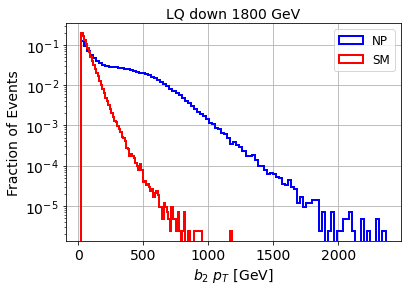

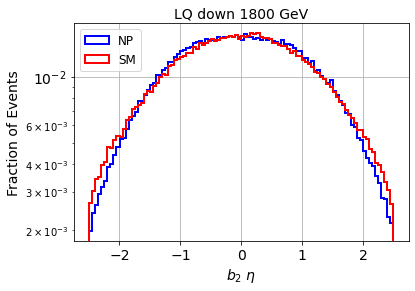

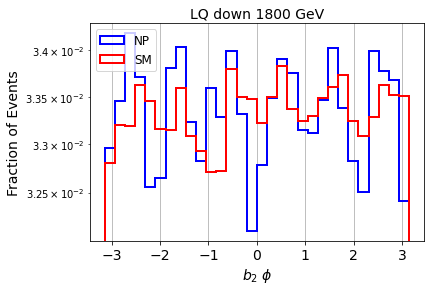

In [10]:
weights = np.ones_like(b2_NP[:,0])/float(len(b2_NP[:,0]))
plt.hist(b2_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,0])/float(len(b2_SM[:,0]))
plt.hist(b2_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,1])/float(len(b2_NP[:,1]))
plt.hist(b2_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,1])/float(len(b2_SM[:,1]))
plt.hist(b2_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,2])/float(len(b2_NP[:,2]))
plt.hist(b2_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,2])/float(len(b2_SM[:,2]))
plt.hist(b2_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

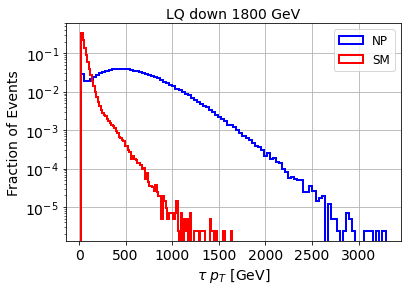

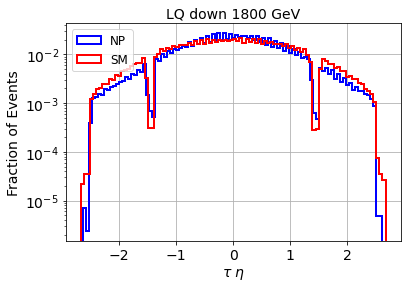

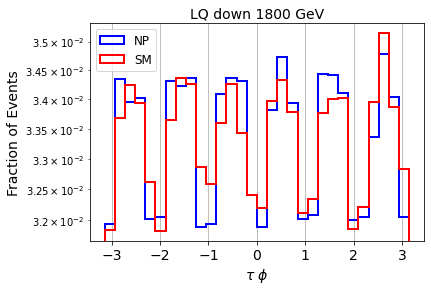

In [11]:
weights = np.ones_like(tau_NP[:,0])/float(len(tau_NP[:,0]))
plt.hist(tau_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,0])/float(len(tau_SM[:,0]))
plt.hist(tau_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,1])/float(len(tau_NP[:,1]))
plt.hist(tau_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,1])/float(len(tau_SM[:,1]))
plt.hist(tau_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,2])/float(len(tau_NP[:,2]))
plt.hist(tau_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,2])/float(len(tau_SM[:,2]))
plt.hist(tau_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

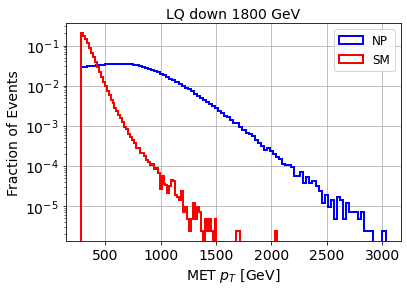

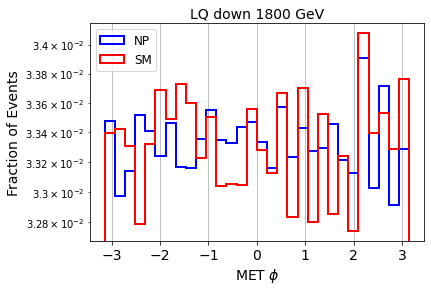

In [12]:
weights = np.ones_like(MET_NP[:,0])/float(len(MET_NP[:,0]))
plt.hist(MET_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,0])/float(len(MET_SM[:,0]))
plt.hist(MET_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()


weights = np.ones_like(MET_NP[:,2])/float(len(MET_NP[:,2]))
plt.hist(MET_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,2])/float(len(MET_SM[:,2]))
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

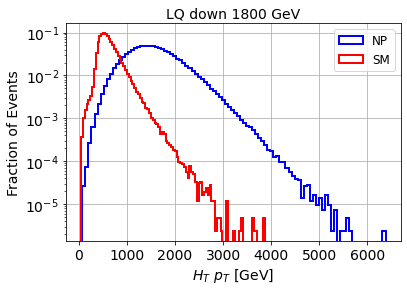

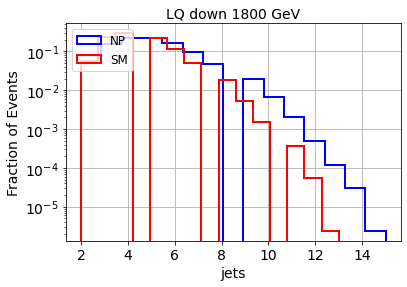

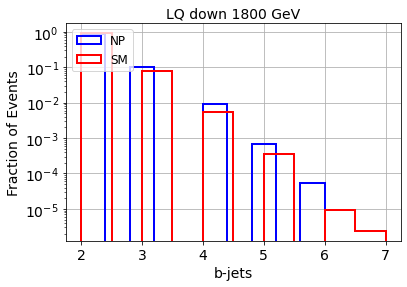

In [13]:
weights = np.ones_like(hadinfo_NP[:,0])/float(len(hadinfo_NP[:,0]))
plt.hist(hadinfo_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,0])/float(len(hadinfo_SM[:,0]))
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$H_T$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,1])/float(len(hadinfo_NP[:,1]))
plt.hist(hadinfo_NP[:,1], weights=weights, bins=15, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,1])/float(len(hadinfo_SM[:,1]))
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,2])/float(len(hadinfo_NP[:,2]))
plt.hist(hadinfo_NP[:,2], weights=weights, bins=10, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,2])/float(len(hadinfo_SM[:,2]))
plt.hist(hadinfo_SM[:,2], weights=weights, bins=10, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("b-jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

### Train-test-val Dataset

In [14]:
# to normalize
scaler = preprocessing.MinMaxScaler()



df = pd.DataFrame()

df['b1-pt']= np.concatenate([b1_SM[:,0],b1_NP[:,0]])
df['b1-eta']= np.concatenate([b1_SM[:,1],b1_NP[:,1]])
df['b1-phi']= np.concatenate([b1_SM[:,2],b1_NP[:,2]])
# remove the used data
del b1_SM
del b1_NP

df['b2-pt']= np.concatenate([b2_SM[:,0],b2_NP[:,0]])
df['b2-eta']= np.concatenate([b2_SM[:,1],b2_NP[:,1]])
df['b2-phi']= np.concatenate([b2_SM[:,2],b2_NP[:,2]])
# remove the used dat
del b2_SM
del b2_NP

df['tau-pt']= np.concatenate([tau_SM[:,0],tau_NP[:,0]])
df['tau-eta']= np.concatenate([tau_SM[:,1],tau_NP[:,1]])
df['tau-phi']= np.concatenate([tau_SM[:,2],tau_NP[:,2]])
# remove the used data
del tau_SM
del tau_NP

df['MET-pt']= np.concatenate([MET_SM[:,0],MET_NP[:,0]])
df['MET-phi']= np.concatenate([MET_SM[:,2],MET_NP[:,2]])
# remove the used data
del MET_SM
del MET_NP

df['HT-pt']= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[:,0]])
df['num-jets']= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[:,1]])
df['num-bjets']= np.concatenate([hadinfo_SM[:,2],hadinfo_NP[:,2]])
# remove the used data
del hadinfo_SM
del hadinfo_NP

df['Y'] = np.concatenate([np.zeros(num_data_SM),np.ones(num_data_NP)])





# NORMALIZE
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# print df to see the data
print(df)


# X and Y for the classifier
X_mon = df[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mon = df[['Y']].values


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)


X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)


print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

           b1-pt    b1-eta    b1-phi     b2-pt    b2-eta    b2-phi    tau-pt  \
0       0.008100  0.639656  0.978199  0.002304  0.475990  0.432368  0.004818   
1       0.018168  0.184874  0.496181  0.019090  0.532013  0.058243  0.001611   
2       0.032779  0.628651  0.564290  0.009030  0.573629  0.929822  0.008907   
3       0.077906  0.276110  0.337842  0.054735  0.332533  0.454806  0.020960   
4       0.038363  0.747299  0.141948  0.009278  0.855342  0.447804  0.004999   
...          ...       ...       ...       ...       ...       ...       ...   
837243  0.226878  0.408964  0.733291  0.071871  0.741297  0.115850  0.171734   
837244  0.431457  0.550020  0.160248  0.024849  0.720488  0.449873  0.302169   
837245  0.157225  0.694678  0.989656  0.026354  0.209684  0.994589  0.312574   
837246  0.050169  0.065826  0.354233  0.036008  0.258703  0.839274  0.127743   
837247  0.286041  0.275310  0.344685  0.184270  0.532613  0.186665  0.244827   

         tau-eta   tau-phi    MET-pt   

### XGBoost (per-event)

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.60550	validation_1-logloss:0.60555
[1]	validation_0-logloss:0.53359	validation_1-logloss:0.53379
[2]	validation_0-logloss:0.47360	validation_1-logloss:0.47392
[3]	validation_0-logloss:0.42287	validation_1-logloss:0.42334
[4]	validation_0-logloss:0.37954	validation_1-logloss:0.38013
[5]	validation_0-logloss:0.34224	validation_1-logloss:0.34287
[6]	validation_0-logloss:0.30993	validation_1-logloss:0.31059
[7]	validation_0-logloss:0.28165	validation_1-logloss:0.28246
[8]	validation_0-logloss:0.25693	validation_1-logloss:0.25780
[9]	validation_0-logloss:0.23525	validation_1-logloss:0.23614
[10]	validation_0-logloss:0.21607	validation_1-logloss:0.21701
[11]	validation_0-logloss:0.19907	validation_1-logloss:0.20013
[12]	validation_0-logloss:0.18405	validation_1-logloss:0.18517
[13]	validation_0-logloss:0.17061	validation_1-logloss:0.17177
[14]	validation_0-logloss:0.15862	validation_1-logloss:0.15986
[15]	validation_0-logloss:0.14798	validation_1-logloss:0.14927
[1

[130]	validation_0-logloss:0.04109	validation_1-logloss:0.04708
[131]	validation_0-logloss:0.04106	validation_1-logloss:0.04708
[132]	validation_0-logloss:0.04103	validation_1-logloss:0.04707
[133]	validation_0-logloss:0.04099	validation_1-logloss:0.04706
[134]	validation_0-logloss:0.04095	validation_1-logloss:0.04704
[135]	validation_0-logloss:0.04092	validation_1-logloss:0.04704
[136]	validation_0-logloss:0.04090	validation_1-logloss:0.04702
[137]	validation_0-logloss:0.04081	validation_1-logloss:0.04699
[138]	validation_0-logloss:0.04078	validation_1-logloss:0.04697
[139]	validation_0-logloss:0.04073	validation_1-logloss:0.04695
[140]	validation_0-logloss:0.04067	validation_1-logloss:0.04693
[141]	validation_0-logloss:0.04066	validation_1-logloss:0.04692
[142]	validation_0-logloss:0.04064	validation_1-logloss:0.04692
[143]	validation_0-logloss:0.04061	validation_1-logloss:0.04692
[144]	validation_0-logloss:0.04058	validation_1-logloss:0.04691
[145]	validation_0-logloss:0.04024	valid

[259]	validation_0-logloss:0.03324	validation_1-logloss:0.04210
[260]	validation_0-logloss:0.03321	validation_1-logloss:0.04208
[261]	validation_0-logloss:0.03319	validation_1-logloss:0.04206
[262]	validation_0-logloss:0.03293	validation_1-logloss:0.04183
[263]	validation_0-logloss:0.03290	validation_1-logloss:0.04182
[264]	validation_0-logloss:0.03285	validation_1-logloss:0.04182
[265]	validation_0-logloss:0.03282	validation_1-logloss:0.04182
[266]	validation_0-logloss:0.03253	validation_1-logloss:0.04153
[267]	validation_0-logloss:0.03247	validation_1-logloss:0.04149
[268]	validation_0-logloss:0.03245	validation_1-logloss:0.04149
[269]	validation_0-logloss:0.03243	validation_1-logloss:0.04150
[270]	validation_0-logloss:0.03240	validation_1-logloss:0.04150
[271]	validation_0-logloss:0.03237	validation_1-logloss:0.04150
[272]	validation_0-logloss:0.03234	validation_1-logloss:0.04149
[273]	validation_0-logloss:0.03232	validation_1-logloss:0.04150
[274]	validation_0-logloss:0.03229	valid

[388]	validation_0-logloss:0.02864	validation_1-logloss:0.04008
[389]	validation_0-logloss:0.02862	validation_1-logloss:0.04007
[390]	validation_0-logloss:0.02860	validation_1-logloss:0.04007
[391]	validation_0-logloss:0.02857	validation_1-logloss:0.04006
[392]	validation_0-logloss:0.02854	validation_1-logloss:0.04005
[393]	validation_0-logloss:0.02853	validation_1-logloss:0.04005
[394]	validation_0-logloss:0.02851	validation_1-logloss:0.04005
[395]	validation_0-logloss:0.02851	validation_1-logloss:0.04005
[396]	validation_0-logloss:0.02849	validation_1-logloss:0.04006
[397]	validation_0-logloss:0.02849	validation_1-logloss:0.04006
[398]	validation_0-logloss:0.02848	validation_1-logloss:0.04006
[399]	validation_0-logloss:0.02847	validation_1-logloss:0.04006
[400]	validation_0-logloss:0.02843	validation_1-logloss:0.04005
[401]	validation_0-logloss:0.02842	validation_1-logloss:0.04005
[402]	validation_0-logloss:0.02835	validation_1-logloss:0.04001
[403]	validation_0-logloss:0.02823	valid

[517]	validation_0-logloss:0.02539	validation_1-logloss:0.03925
[518]	validation_0-logloss:0.02538	validation_1-logloss:0.03925
[519]	validation_0-logloss:0.02536	validation_1-logloss:0.03925
[520]	validation_0-logloss:0.02534	validation_1-logloss:0.03925
[521]	validation_0-logloss:0.02532	validation_1-logloss:0.03925
[522]	validation_0-logloss:0.02531	validation_1-logloss:0.03925
[523]	validation_0-logloss:0.02528	validation_1-logloss:0.03925
[524]	validation_0-logloss:0.02526	validation_1-logloss:0.03925
[525]	validation_0-logloss:0.02525	validation_1-logloss:0.03926
[526]	validation_0-logloss:0.02524	validation_1-logloss:0.03926
[527]	validation_0-logloss:0.02523	validation_1-logloss:0.03926
[528]	validation_0-logloss:0.02521	validation_1-logloss:0.03926
[529]	validation_0-logloss:0.02519	validation_1-logloss:0.03926
[530]	validation_0-logloss:0.02518	validation_1-logloss:0.03926
[531]	validation_0-logloss:0.02518	validation_1-logloss:0.03926
[532]	validation_0-logloss:0.02517	valid

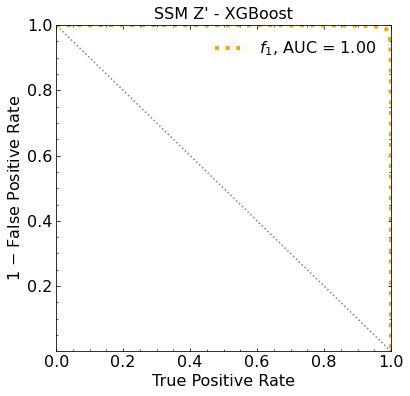

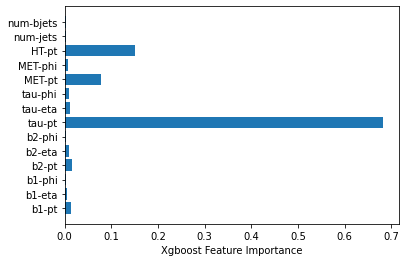

In [15]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"SSM Z' - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




# THIS IS THE DEFAULT FEATURE IMPORTANCE: gain
feature_names = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])
plt.barh(feature_names, classifier.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
plt.show()

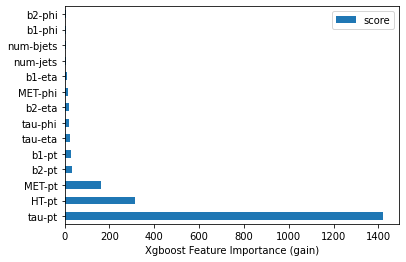

In [16]:
keys = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh') ## plot top 20 features
plt.xlabel("Xgboost Feature Importance (gain)")
plt.show()

Classification score:


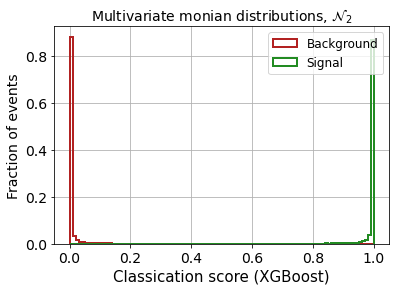

In [17]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate monian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

## METHODS

### 0. Ensembles characteristics

In [7]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = round(139 * totalcrossSM)    # luminosity * cross * aceptance
print('B_expected: ', B_expected)

print('S_expected: ', round(139 * crossfidNP))    # luminosity * cross * aceptance
S_expected = [1,3,5,7,10,20,50]




# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = [ S_expected[iii]/(1.*B_expected) for iii in range(len(S_expected)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(S_expected)) ]

B_expected:  1428
S_expected:  0


In [8]:
139 * crossfidNP

0.26871932478658994

### 1. BIN LOG LIKELIHOOD

B_expected:  1428
S_expected:  1
S/$\sqrt{B}$:  0.026462806201248155

 If  285  =  175    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take a bit... 



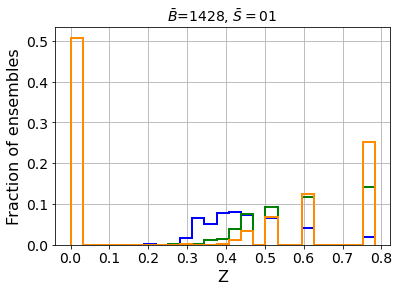

Z_bins_16bins:  0.0
Z_bins_16bins_std:  0.23319384459525355
Z_bins_50bins:  0.0
Z_bins_50bins_std:  0.31218123978725737
Z_bins_100bins:  0.0
Z_bins_100bins_std:  0.3468583685590898

 -------------------------------- 

B_expected:  1428
S_expected:  3
S/$\sqrt{B}$:  0.07938841860374447

 If  287  =  175    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take a bit... 



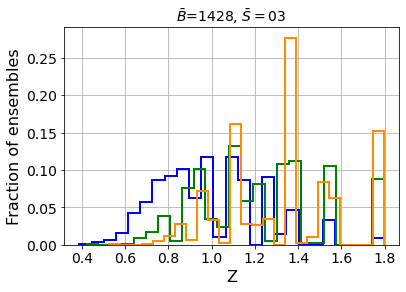

Z_bins_16bins:  0.9669778991290626
Z_bins_16bins_std:  0.24189081519775565
Z_bins_50bins:  1.2252831685163774
Z_bins_50bins_std:  0.28048388455286016
Z_bins_100bins:  1.3426747270518578
Z_bins_100bins_std:  0.2747941367937143

 -------------------------------- 

B_expected:  1428
S_expected:  5
S/$\sqrt{B}$:  0.13231403100624078

 If  287  =  175    then the proposed range has to be extended
n_ensembles (actual):  1866

 This may take a bit... 



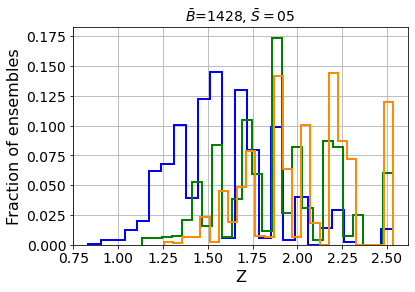

Z_bins_16bins:  1.5667873357671862
Z_bins_16bins_std:  0.2902962355913
Z_bins_50bins:  1.8873919439966884
Z_bins_50bins_std:  0.30779805195535087
Z_bins_100bins:  2.028552311854354
Z_bins_100bins_std:  0.2952370340872844

 -------------------------------- 

B_expected:  1428
S_expected:  7
S/$\sqrt{B}$:  0.18523964340873708

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take a bit... 



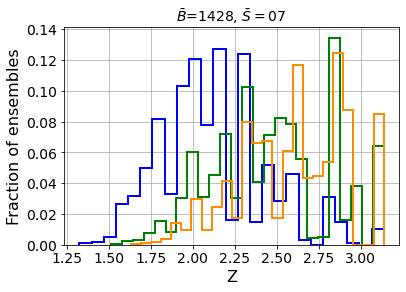

Z_bins_16bins:  2.072664823882715
Z_bins_16bins_std:  0.31963341421676106
Z_bins_50bins:  2.4539828660509126
Z_bins_50bins_std:  0.34874575738194624
Z_bins_100bins:  2.65144992417809
Z_bins_100bins_std:  0.31671925158846553

 -------------------------------- 

B_expected:  1428
S_expected:  10
S/$\sqrt{B}$:  0.26462806201248157

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take a bit... 



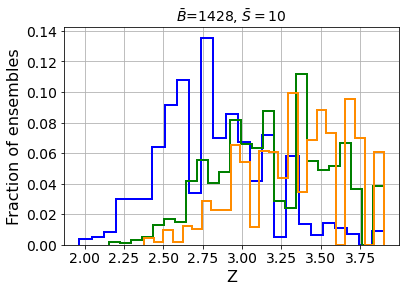

Z_bins_16bins:  2.7755730630247184
Z_bins_16bins_std:  0.34964232101002296
Z_bins_50bins:  3.158780817346632
Z_bins_50bins_std:  0.3624600882727141
Z_bins_100bins:  3.3469355517009047
Z_bins_100bins_std:  0.3290465263002882

 -------------------------------- 

B_expected:  1428
S_expected:  20
S/$\sqrt{B}$:  0.5292561240249631

 If  289  =  177    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take a bit... 



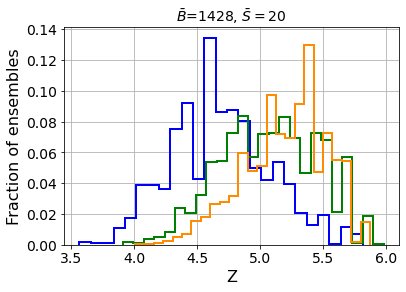

Z_bins_16bins:  4.661682332752518
Z_bins_16bins_std:  0.39631087036857454
Z_bins_50bins:  5.097713017817055
Z_bins_50bins_std:  0.3804243741774675
Z_bins_100bins:  5.23558152138976
Z_bins_100bins_std:  0.3266002360290262

 -------------------------------- 

B_expected:  1428
S_expected:  50
S/$\sqrt{B}$:  1.3231403100624077

 If  295  =  178    then the proposed range has to be extended
n_ensembles (actual):  1863

 This may take a bit... 



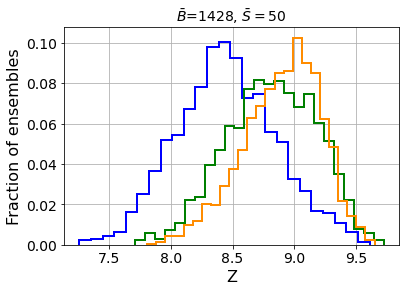

Z_bins_16bins:  8.446195656842281
Z_bins_16bins_std:  0.4034201385690625
Z_bins_50bins:  8.816645696540146
Z_bins_50bins_std:  0.3620469088540246
Z_bins_100bins:  8.931635009787678
Z_bins_100bins_std:  0.31393894889911295

 -------------------------------- 



In [20]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_Z_bins_XG_16bins_std = []
store_Z_bins_XG_50bins_std = []
store_Z_bins_XG_100bins_std = []

# store_Z_bins_XG_16bins_noUnc = []
# store_Z_bins_XG_50bins_noUnc = []
# store_Z_bins_XG_100bins_noUnc = []

# store_Z_bins_XG_16bins_noUnc_std = []
# store_Z_bins_XG_50bins_noUnc_std = []
# store_Z_bins_XG_100bins_noUnc_std = []


indices_B = [i for i in range(len(pred_XG_SM))]
indices_S = [i for i in range(len(pred_XG_NP))]







for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    print('\n This may take a bit... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    Z_bins_16bins_aux = []
    Z_bins_50bins_aux = []
    Z_bins_100bins_aux = []
    
#     Z_bins_16bins_noUnc_aux = []
#     Z_bins_50bins_noUnc_aux = []
#     Z_bins_100bins_noUnc_aux = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            ran_ind_B = np.random.choice(indices_B, list_B_per_ensembles[bb])
            ran_ind_S = np.random.choice(indices_S, list_S_per_ensembles[bb])
            

            
            pred_XG_SM_shuf = []
            
            pred_XG_NP_shuf = []
            
            for ill in ran_ind_B:
                pred_XG_SM_shuf.append(pred_XG_SM[ill])
                
            for ill in ran_ind_S:
                pred_XG_NP_shuf.append(pred_XG_NP[ill])
                
            
            
            ############
            # 16 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:       

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(16), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(16), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_16bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_16bins_aux.append(Z_bins_16bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_16bins**2))/((back_prom_sig_16bins**2)+back_prom) ))**0.5 )

#             Z_bins_16bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_16bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_16bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_16bins_aux.append(Z_bins_16bins_sig)
            
            
            
            
            
            ############
            # 50 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(50), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(50), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_50bins_aux.append(Z_bins_50bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_50bins**2))/((back_prom_sig_50bins**2)+back_prom) ))**0.5 )

#             Z_bins_50bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_50bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_50bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_50bins_aux.append(Z_bins_50bins_sig)
        
        
        
        
        
        
            ############
            # 100 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(100), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(100), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
            ## then the signif Z^binned-Asimov without uncertainties:
            Z_bins_100bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

            Z_bins_100bins_aux.append(Z_bins_100bins)
                    

#             # then the signif Z^binned-Asimov with uncertainties in the background:

#             B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_100bins**2))/((back_prom_sig_100bins**2)+back_prom) ))**0.5 )

#             Z_bins_100bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) - ( (back_prom**2/(back_prom_sig_100bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_100bins**2))) ) + sig_prom ) )**0.5

#             Z_bins_100bins_aux.append(Z_bins_100bins_sig)
            
    
    
    
  
    # Histogram of q_muhats

    weights = np.ones_like(Z_bins_16bins_aux)/float(len(Z_bins_16bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_16bins_aux, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    weights = np.ones_like(Z_bins_50bins_aux)/float(len(Z_bins_50bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_50bins_aux, 25, weights=weights, histtype='step', color='green', linewidth=2)
    weights = np.ones_like(Z_bins_100bins_aux)/float(len(Z_bins_100bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_100bins_aux, 25, weights=weights, histtype='step', color='darkorange', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Z",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()
    
    
    # 16 bins #
    # Remove nan if any
    Z_bins_16bins_aux = [x for x in Z_bins_16bins_aux if x == x]
    for jk in range(len(Z_bins_16bins_aux)):
        if Z_bins_16bins_aux[jk] < 0:
            Z_bins_16bins_aux[jk] = 0

    Z_bins_16bins = np.median(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins.append(Z_bins_16bins)
    
    Z_bins_16bins_std = np.std(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins_std.append(Z_bins_16bins_std)

    print('Z_bins_16bins: ', Z_bins_16bins)
    print('Z_bins_16bins_std: ', Z_bins_16bins_std)

    
#     # Remove nan if any
#     Z_bins_16bins_noUnc_aux = [x for x in Z_bins_16bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_16bins_noUnc_aux)):
#         if Z_bins_16bins_noUnc_aux[jk] < 0:
#             Z_bins_16bins_noUnc_aux[jk] = 0

#     Z_bins_16bins_noUnc = np.median(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc.append(Z_bins_16bins_noUnc)
    
#     Z_bins_16bins_noUnc_std = np.std(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc_std.append(Z_bins_16bins_noUnc_std)

#     print('Z_bins_16bins_noUnc: ', Z_bins_16bins_noUnc)
#     print('Z_bins_16bins_noUnc_std: ', Z_bins_16bins_noUnc_std)
    
    
    # 50 bins #
    # Remove nan if any
    Z_bins_50bins_aux = [x for x in Z_bins_50bins_aux if x == x]
    for jk in range(len(Z_bins_50bins_aux)):
        if Z_bins_50bins_aux[jk] < 0:
            Z_bins_50bins_aux[jk] = 0

    Z_bins_50bins = np.median(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins.append(Z_bins_50bins)
    
    Z_bins_50bins_std = np.std(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins_std.append(Z_bins_50bins_std)

    print('Z_bins_50bins: ', Z_bins_50bins)
    print('Z_bins_50bins_std: ', Z_bins_50bins_std)
    
    
#     # Remove nan if any
#     Z_bins_50bins_noUnc_aux = [x for x in Z_bins_50bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_50bins_noUnc_aux)):
#         if Z_bins_50bins_noUnc_aux[jk] < 0:
#             Z_bins_50bins_noUnc_aux[jk] = 0

#     Z_bins_50bins_noUnc = np.median(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc.append(Z_bins_50bins_noUnc)
    
#     Z_bins_50bins_noUnc_std = np.std(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc_std.append(Z_bins_50bins_noUnc_std)

#     print('Z_bins_50bins_noUnc: ', Z_bins_50bins_noUnc)
#     print('Z_bins_50bins_noUnc_std: ', Z_bins_50bins_noUnc_std)
    
    
    # 100 bins #
    # Remove nan if any
    Z_bins_100bins_aux = [x for x in Z_bins_100bins_aux if x == x]
    for jk in range(len(Z_bins_100bins_aux)):
        if Z_bins_100bins_aux[jk] < 0:
            Z_bins_100bins_aux[jk] = 0

    Z_bins_100bins = np.median(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins.append(Z_bins_100bins)
    
    Z_bins_100bins_std = np.std(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins_std.append(Z_bins_100bins_std)

    print('Z_bins_100bins: ', Z_bins_100bins)
    print('Z_bins_100bins_std: ', Z_bins_100bins_std)
    
    
#     # Remove nan if any
#     Z_bins_100bins_noUnc_aux = [x for x in Z_bins_100bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_100bins_noUnc_aux)):
#         if Z_bins_100bins_noUnc_aux[jk] < 0:
#             Z_bins_100bins_noUnc_aux[jk] = 0

#     Z_bins_100bins_noUnc = np.median(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc.append(Z_bins_100bins_noUnc)
    
#     Z_bins_100bins_noUnc_std = np.std(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc_std.append(Z_bins_100bins_noUnc_std)

#     print('Z_bins_100bins_noUnc: ', Z_bins_100bins_noUnc)
#     print('Z_bins_100bins_noUnc_std: ', Z_bins_100bins_noUnc_std)

    print('\n -------------------------------- \n')

In [21]:
print(store_Z_bins_XG_16bins)
print(store_Z_bins_XG_50bins)
print(store_Z_bins_XG_100bins)

print(store_Z_bins_XG_16bins_std)
print(store_Z_bins_XG_50bins_std)
print(store_Z_bins_XG_100bins_std)

[0.0, 0.9669778991290626, 1.5667873357671862, 2.072664823882715, 2.7755730630247184, 4.661682332752518, 8.446195656842281]
[0.0, 1.2252831685163774, 1.8873919439966884, 2.4539828660509126, 3.158780817346632, 5.097713017817055, 8.816645696540146]
[0.0, 1.3426747270518578, 2.028552311854354, 2.65144992417809, 3.3469355517009047, 5.23558152138976, 8.931635009787678]
[0.23319384459525355, 0.24189081519775565, 0.2902962355913, 0.31963341421676106, 0.34964232101002296, 0.39631087036857454, 0.4034201385690625]
[0.31218123978725737, 0.28048388455286016, 0.30779805195535087, 0.34874575738194624, 0.3624600882727141, 0.3804243741774675, 0.3620469088540246]
[0.3468583685590898, 0.2747941367937143, 0.2952370340872844, 0.31671925158846553, 0.3290465263002882, 0.3266002360290262, 0.31393894889911295]


In [9]:
store_Z_bins_XG_16bins = [0.0, 0.9669778991290626, 1.5667873357671862, 2.072664823882715, 2.7755730630247184, 4.661682332752518, 8.446195656842281]
store_Z_bins_XG_50bins = [0.0, 1.2252831685163774, 1.8873919439966884, 2.4539828660509126, 3.158780817346632, 5.097713017817055, 8.816645696540146]
store_Z_bins_XG_100bins = [0.0, 1.3426747270518578, 2.028552311854354, 2.65144992417809, 3.3469355517009047, 5.23558152138976, 8.931635009787678]

store_Z_bins_XG_16bins_std = [0.23319384459525355, 0.24189081519775565, 0.2902962355913, 0.31963341421676106, 0.34964232101002296, 0.39631087036857454, 0.4034201385690625]
store_Z_bins_XG_50bins_std = [0.31218123978725737, 0.28048388455286016, 0.30779805195535087, 0.34874575738194624, 0.3624600882727141, 0.3804243741774675, 0.3620469088540246]
store_Z_bins_XG_100bins_std =[0.3468583685590898, 0.2747941367937143, 0.2952370340872844, 0.31671925158846553, 0.3290465263002882, 0.3266002360290262, 0.31393894889911295]

In [10]:
store_Z_bins_XG_16bins_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]
store_Z_bins_XG_16bins_min = [i-j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]

store_Z_bins_XG_50bins_plus = [i+j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]
store_Z_bins_XG_50bins_min = [i-j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]

store_Z_bins_XG_100bins_plus = [i+j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]
store_Z_bins_XG_100bins_min = [i-j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]

<ipython-input-11-4a6e58b0e125>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
<ipython-input-11-4a6e58b0e125>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
<ipython-input-11-4a6e58b0e125>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)')


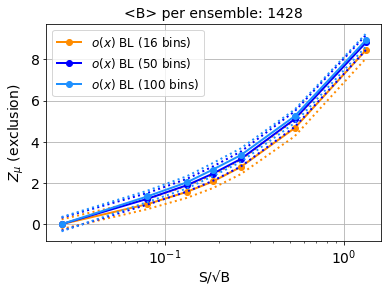

In [11]:
#########
# PLOTS #
#########

posX = []

for i in range(len(S_expected)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### MLL KDE

#### KDE

/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf 13495.11542861 12039.43442354
 10501.33776866  8883.36422453  7204.56415889  5476.72344327
  3711.97934344  1914.68768808   106.61380092 -1688.91628758]
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.013538761800225447, kernel='epanechnikov')


/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf 14651.17940784 13338.98261374 11929.4972407
 10412.59311629  8816.44302539  7159.9795678   5462.05840727
  3715.42957171  1925.73387588   110.91253644 -1685.448732  ]
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.008287452507534925, kernel='epanechnikov')


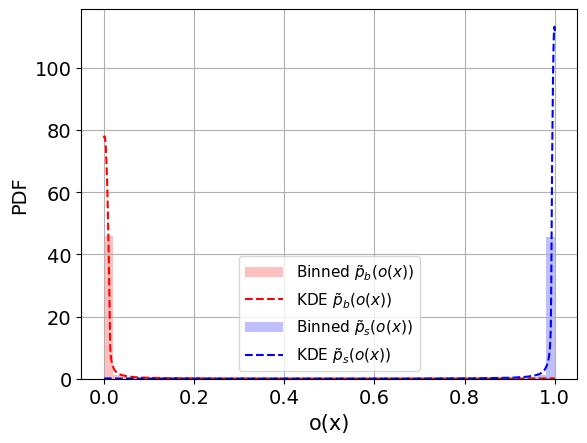

In [24]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

#SM_bandwidth = 0.0127
#NP_bandwidth = 0.0127

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

B_expected:  1428


/tmp/ipykernel_12835/4108206064.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
/tmp/ipykernel_12835/4108206064.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
/tmp/ipykernel_12835/4108206064.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)')


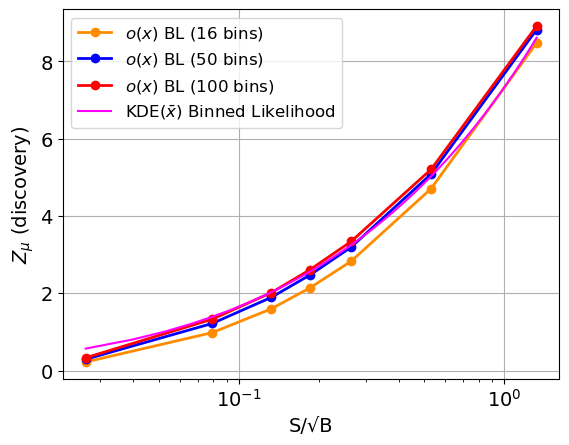

In [25]:
# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', B_expected)

# values of S / sqrt{B} to test 
soversqrtB = np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin: 
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
    
    # Z value:
    #Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

    
    
    
# PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(soversqrtB, Zvals, color='magenta', label=r'KDE$(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### MLL KDE

In [26]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

In [27]:
KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

B_expected:  1428
S_expected:  1
S/$\sqrt{B}$:  0.026462806201248155
n_ensembles (initial):  2000

 If  285  =  175    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take long... 



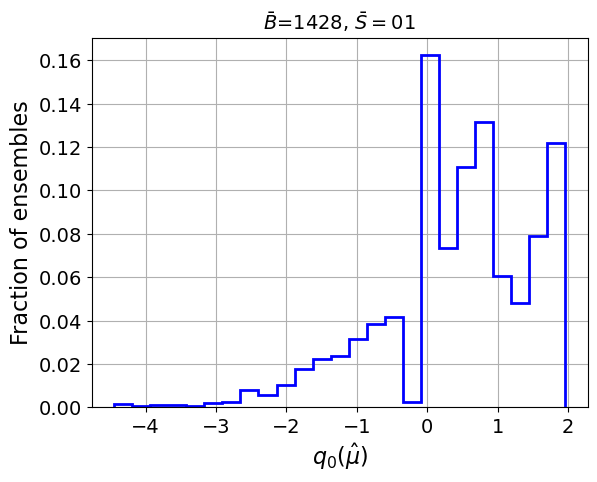

muhat mean:  0.12071734475374732
median q_muhat_KDE:  0.569575788153337
Z_KDE:  0.7547024500777356
Z_KDE mu=0:  0.7547024500777356
std Z_KDE:  0.4338190838004693
std Z_KDE mu=0:  0.4383215420726719

 -------------------------------- 

B_expected:  1428
S_expected:  3
S/$\sqrt{B}$:  0.07938841860374447
n_ensembles (initial):  2000

 If  287  =  175    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take long... 



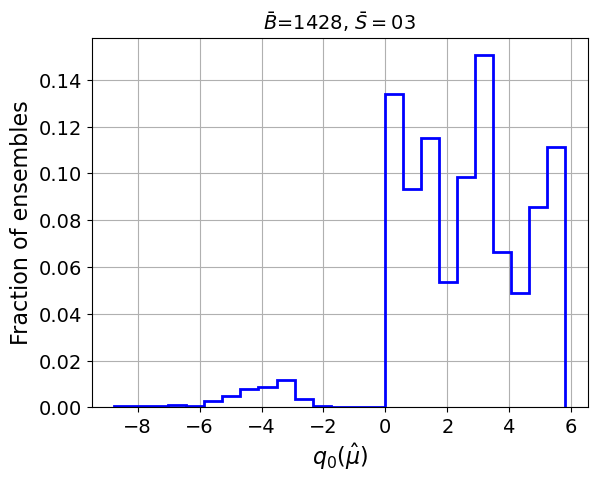

muhat mean:  0.14917023554603853
median q_muhat_KDE:  2.727062921439432
Z_KDE:  1.6513821245972817
Z_KDE mu=0:  1.6513821245972817
std Z_KDE:  0.5418461569955983
std Z_KDE mu=0:  0.5722857423469937

 -------------------------------- 

B_expected:  1428
S_expected:  5
S/$\sqrt{B}$:  0.13231403100624078
n_ensembles (initial):  2000

 If  287  =  175    then the proposed range has to be extended
n_ensembles (actual):  1866

 This may take long... 



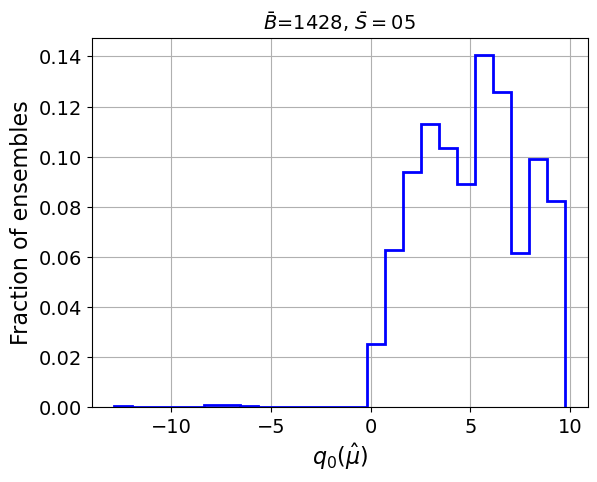

muhat mean:  0.10653804930332263
median q_muhat_KDE:  5.328567712247109
Z_KDE:  2.3083690589347077
Z_KDE mu=0:  2.3083690589347077
std Z_KDE:  0.5441673933191855
std Z_KDE mu=0:  0.6036070446259683

 -------------------------------- 

B_expected:  1428
S_expected:  7
S/$\sqrt{B}$:  0.18523964340873708
n_ensembles (initial):  2000

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take long... 



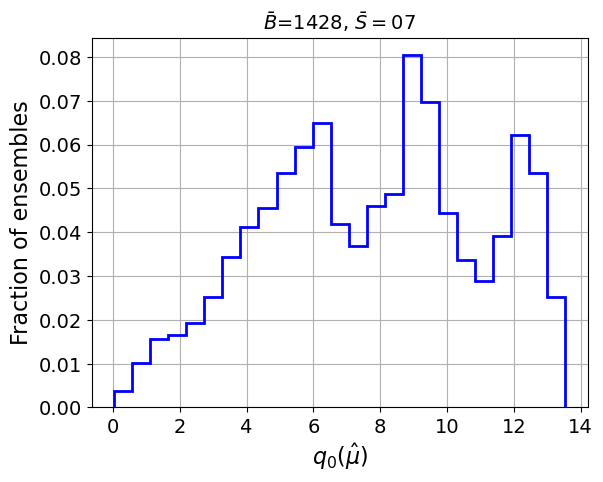

muhat mean:  0.09094804499196572
median q_muhat_KDE:  7.985877031832574
Z_KDE:  2.8259294102706414
Z_KDE mu=0:  2.8259294102706414
std Z_KDE:  0.5726514513369062
std Z_KDE mu=0:  0.6460965564518483

 -------------------------------- 

B_expected:  1428
S_expected:  10
S/$\sqrt{B}$:  0.26462806201248157
n_ensembles (initial):  2000

 If  287  =  176    then the proposed range has to be extended
n_ensembles (actual):  1867

 This may take long... 



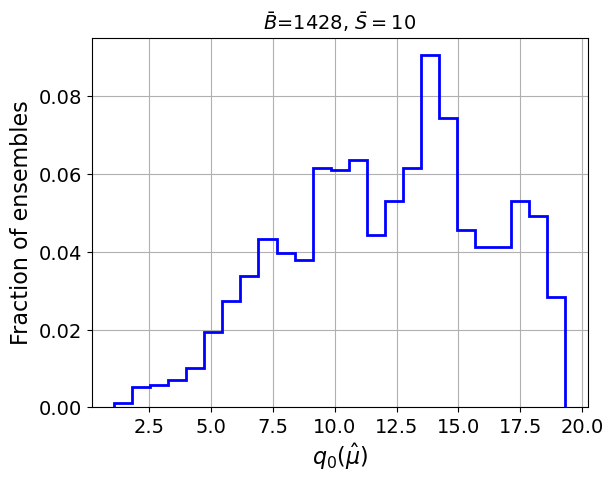

muhat mean:  0.06572040707016605
median q_muhat_KDE:  12.551087036063354
Z_KDE:  3.5427513370350106
Z_KDE mu=0:  3.5427513370350106
std Z_KDE:  0.5573532375915565
std Z_KDE mu=0:  0.6387749394660056

 -------------------------------- 

B_expected:  1428
S_expected:  20
S/$\sqrt{B}$:  0.5292561240249631
n_ensembles (initial):  2000

 If  289  =  177    then the proposed range has to be extended
n_ensembles (actual):  1868

 This may take long... 



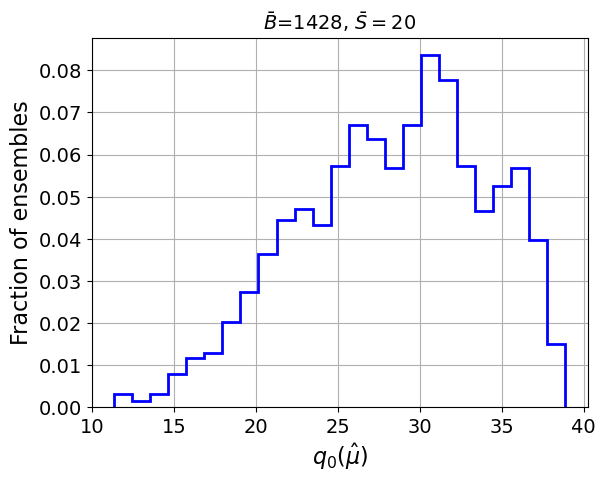

muhat mean:  0.03642933618843683
median q_muhat_KDE:  28.89176282615338
Z_KDE:  5.375105843251217
Z_KDE mu=0:  5.375446053423099
std Z_KDE:  0.5269104351114147
std Z_KDE mu=0:  0.5893751939247881

 -------------------------------- 

B_expected:  1428
S_expected:  50
S/$\sqrt{B}$:  1.3231403100624077
n_ensembles (initial):  2000

 If  295  =  178    then the proposed range has to be extended
n_ensembles (actual):  1863

 This may take long... 



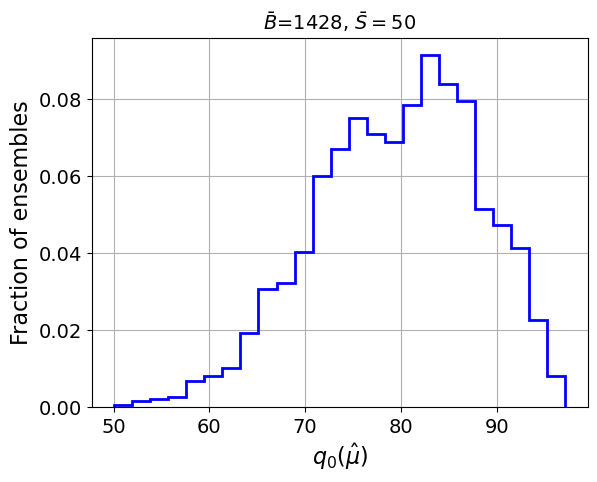

muhat mean:  0.024074074074074074
median q_muhat_KDE:  80.26368586001477
Z_KDE:  8.95900027123645
Z_KDE mu=0:  8.972710963145637
std Z_KDE:  0.47015732038073277
std Z_KDE mu=0:  0.5028925735519165

 -------------------------------- 



In [28]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break


            muhat_selected_KDE_list.append(muhat_selected_KDE)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')

In [29]:
print(store_muhat_mean_MLL_KDE)

print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_Z_MLL_KDE_std)
print(store_Z_MLL_KDE_std_mu0)

[0.12071734475374732, 0.14917023554603853, 0.10653804930332263, 0.09094804499196572, 0.06572040707016605, 0.03642933618843683, 0.024074074074074074]
[0.7547024500777356, 1.6513821245972817, 2.3083690589347077, 2.8259294102706414, 3.5427513370350106, 5.375105843251217, 8.95900027123645]
[0.7547024500777356, 1.6513821245972817, 2.3083690589347077, 2.8259294102706414, 3.5427513370350106, 5.375446053423099, 8.972710963145637]
[0.4338190838004693, 0.5418461569955983, 0.5441673933191855, 0.5726514513369062, 0.5573532375915565, 0.5269104351114147, 0.47015732038073277]
[0.4383215420726719, 0.5722857423469937, 0.6036070446259683, 0.6460965564518483, 0.6387749394660056, 0.5893751939247881, 0.5028925735519165]


In [12]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_MLL_KDE = [0.12071734475374732, 0.14917023554603853, 0.10653804930332263, 0.09094804499196572, 0.06572040707016605, 0.03642933618843683, 0.024074074074074074]

store_Z_MLL_KDE = [0.7547024500777356, 1.6513821245972817, 2.3083690589347077, 2.8259294102706414, 3.5427513370350106, 5.375105843251217, 8.95900027123645]
store_Z_MLL_KDE_mu0 = [0.7547024500777356, 1.6513821245972817, 2.3083690589347077, 2.8259294102706414, 3.5427513370350106, 5.375446053423099, 8.972710963145637]

store_Z_MLL_KDE_std = [0.4338190838004693, 0.5418461569955983, 0.5441673933191855, 0.5726514513369062, 0.5573532375915565, 0.5269104351114147, 0.47015732038073277]
store_Z_MLL_KDE_std_mu0 = [0.4383215420726719, 0.5722857423469937, 0.6036070446259683, 0.6460965564518483, 0.6387749394660056, 0.5893751939247881, 0.5028925735519165]

In [13]:
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

<ipython-input-14-ba6818921466>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_muhat_mean_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')


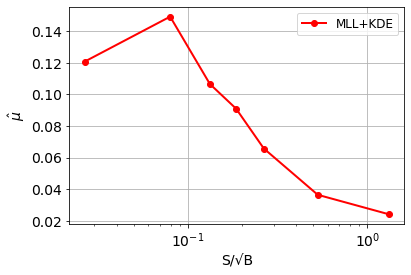

<ipython-input-14-ba6818921466>:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')
<ipython-input-14-ba6818921466>:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ":ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_MLL_KDE_plus, ':ok', color='red', lw=lw)
<ipython-input-14-ba6818921466>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ":ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_MLL_KDE_min, ':ok', color='red', lw=lw)
<ipython-input-14-ba6818921466>:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pos

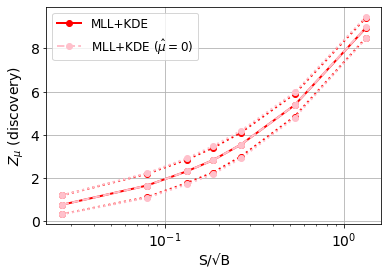

<ipython-input-14-ba6818921466>:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
<ipython-input-14-ba6818921466>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
<ipython-input-14-ba6818921466>:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)')
<ipython-input-14-ba6818921466>:70: UserWarning: color is redundantly defined by the 'color' keyword argume

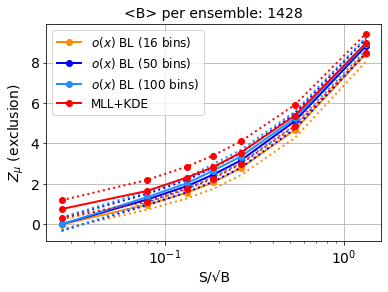

In [14]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':ok', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':ok', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0, '--ok', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')
plt.plot(posX, store_Z_MLL_KDE_mu0_plus, ':ok', color='pink', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0_min, ':ok', color='pink', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':ok', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':ok', color='red', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### Interpolate

In [15]:
# if Z < 0 -> Z=0

store_Z_bins_XG_16bins = [0 if i < 0 else i for i in store_Z_bins_XG_16bins]
store_Z_bins_XG_16bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_plus]
store_Z_bins_XG_16bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_min]

store_Z_bins_XG_50bins = [0 if i < 0 else i for i in store_Z_bins_XG_50bins]
store_Z_bins_XG_50bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_plus]
store_Z_bins_XG_50bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_min]

store_Z_bins_XG_100bins = [0 if i < 0 else i for i in store_Z_bins_XG_100bins]
store_Z_bins_XG_100bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_plus]
store_Z_bins_XG_100bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_min]

store_Z_MLL_KDE = [0 if i < 0 else i for i in store_Z_MLL_KDE]
store_Z_MLL_KDE_plus = [0 if i < 0 else i for i in store_Z_MLL_KDE_plus]
store_Z_MLL_KDE_min = [0 if i < 0 else i for i in store_Z_MLL_KDE_min]

In [16]:
# add zero

posX = [0.001] + posX

store_Z_bins_XG_16bins = [0] + store_Z_bins_XG_16bins
store_Z_bins_XG_16bins_plus = [0] + store_Z_bins_XG_16bins_plus
store_Z_bins_XG_16bins_min = [0] + store_Z_bins_XG_16bins_min

store_Z_bins_XG_50bins = [0] + store_Z_bins_XG_50bins
store_Z_bins_XG_50bins_plus = [0] + store_Z_bins_XG_50bins_plus
store_Z_bins_XG_50bins_min = [0] + store_Z_bins_XG_50bins_min

store_Z_bins_XG_100bins = [0] + store_Z_bins_XG_100bins
store_Z_bins_XG_100bins_plus = [0] + store_Z_bins_XG_100bins_plus
store_Z_bins_XG_100bins_min = [0] + store_Z_bins_XG_100bins_min

store_Z_MLL_KDE = [0] + store_Z_MLL_KDE
store_Z_MLL_KDE_plus = [0] + store_Z_MLL_KDE_plus
store_Z_MLL_KDE_min = [0] + store_Z_MLL_KDE_min

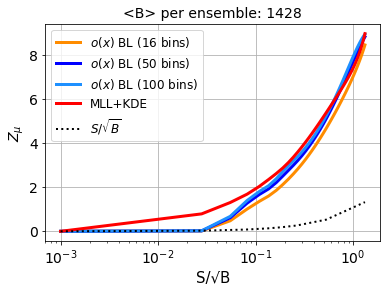

In [17]:
  
# Interpolation, cubic
f_16bins = interp1d(posX, store_Z_bins_XG_16bins, kind='cubic')
f_16bins_plus = interp1d(posX, store_Z_bins_XG_16bins_plus, kind='cubic')
f_16bins_min = interp1d(posX, store_Z_bins_XG_16bins_min, kind='cubic')

f_50bins = interp1d(posX, store_Z_bins_XG_50bins, kind='cubic')
f_50bins_plus = interp1d(posX, store_Z_bins_XG_50bins_plus, kind='cubic')
f_50bins_min = interp1d(posX, store_Z_bins_XG_50bins_min, kind='cubic')

f_100bins = interp1d(posX, store_Z_bins_XG_100bins, kind='cubic')
f_100bins_plus = interp1d(posX, store_Z_bins_XG_100bins_plus, kind='cubic')
f_100bins_min = interp1d(posX, store_Z_bins_XG_100bins_min, kind='cubic')

f_MLL_KDE = interp1d(posX, store_Z_MLL_KDE, kind='cubic')
f_MLL_KDE_plus = interp1d(posX, store_Z_MLL_KDE_plus, kind='cubic')
f_MLL_KDE_min = interp1d(posX, store_Z_MLL_KDE_min, kind='cubic')



# x to plot
plotX = np.linspace(min(posX), max(posX), num=50, endpoint=True)



plt.figure()
lw = 2

plt.plot(plotX, f_16bins(plotX), '-', color='darkorange', lw=3, label=r'$o(x)$ BL (16 bins)')
plt.plot(plotX, f_50bins(plotX), '-', color='blue', lw=3, label=r'$o(x)$ BL (50 bins)')
plt.plot(plotX, f_100bins(plotX), '-', color='dodgerblue', lw=3, label=r'$o(x)$ BL (100 bins)')
plt.plot(plotX, f_MLL_KDE(plotX), '-', color='red', lw=3, label='MLL+KDE')
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.ylim([0., 6])
#plt.xlim([0.06, 10])
#plt.ylim([0., 3])
#plt.xlim([0.1, 0.2])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=15)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [18]:
# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solve(fn, value, x=0.1, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

In [19]:
# We need the ratio of the fiducial cross-sections for different values of beta to rescale

beta = [0.1,0.3,0.5,0.7,0.9]

# m_LQ = [ 800, 1000, 1200, 1400, 1600, 1800 ]  GeV
ind_mass = 5

fidcross_beta01 = [0.3163628, 0.0741753, 0.01952626, 0.0044892, 0.0016499700000000002, 0.00046830800000000007]
fidcross_beta03 = [0.559062, 0.13798409999999997, 0.03652792, 0.01062024, 0.002733768, 0.0008702760000000001]
fidcross_beta05 = [0.74664, 0.1822585, 0.04825368, 0.012417530000000001, 0.0032513399999999997, 0.001112082]
fidcross_beta07 = [0.6483749999999999, 0.165285, 0.04282562, 0.01281222, 0.003864048, 0.001097392]
fidcross_beta09 = [0.43799099999999996, 0.113778, 0.03572283, 0.010101599999999999, 0.0030826390000000003, 0.0008606400000000001]


S01 = (139 * crossfidNP) * (fidcross_beta01[ind_mass]/fidcross_beta05[ind_mass])
S03 = (139 * crossfidNP) * (fidcross_beta03[ind_mass]/fidcross_beta05[ind_mass])
S05 = (139 * crossfidNP) * (fidcross_beta05[ind_mass]/fidcross_beta05[ind_mass])
S07 = (139 * crossfidNP) * (fidcross_beta07[ind_mass]/fidcross_beta05[ind_mass])
S09 = (139 * crossfidNP) * (fidcross_beta09[ind_mass]/fidcross_beta05[ind_mass])

# S01 = round(139 * crossfidNP) * (0.027999/0.05013519)
# S03 = round(139 * crossfidNP) * (0.04348762/0.05013519)
# S05 = round(139 * crossfidNP) * (1.)
# S07 = round(139 * crossfidNP) * (0.05433536/0.05013519)
# S09 = round(139 * crossfidNP) * (0.0391902/0.05013519)

S_exp_LQ = [S01,S03,S05,S07,S09]

print(S_exp_LQ)

[0.11316018922359897, 0.2102902295855651, 0.26871932478658994, 0.26516968826597814, 0.2079618226752441]


In [20]:
# Finally, the value of Z for each value of beta, for this particular LQ

results_16bins_beta = []
results_16bins_beta_plus = []
results_16bins_beta_min = []

results_50bins_beta = []
results_50bins_beta_plus = []
results_50bins_beta_min = []

results_100bins_beta = []
results_100bins_beta_plus = []
results_100bins_beta_min = []

results_MLL_KDE_beta = []
results_MLL_KDE_beta_plus = []
results_MLL_KDE_beta_min = []



for signal in S_exp_LQ:    
    results_16bins_beta.append( f_16bins(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_plus.append( f_16bins_plus(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_min.append( f_16bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_50bins_beta.append( f_50bins(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_plus.append( f_50bins_plus(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_min.append( f_50bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_100bins_beta.append( f_100bins(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_plus.append( f_100bins_plus(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_min.append( f_100bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_MLL_KDE_beta.append( f_MLL_KDE(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_plus.append( f_MLL_KDE_plus(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_min.append( f_MLL_KDE_min(signal/(B_expected**0.5)).tolist() )

In [21]:
print( results_16bins_beta )
print( results_16bins_beta_plus )
print( results_16bins_beta_min )

print( results_50bins_beta )
print( results_50bins_beta_plus )
print( results_50bins_beta_min )

print( results_100bins_beta )
print( results_100bins_beta_plus )
print( results_100bins_beta_min )

print( results_MLL_KDE_beta )
print( results_MLL_KDE_beta_plus )
print( results_MLL_KDE_beta_min )

np.savetxt('saved-results/LQdown1800GeV.txt', [results_16bins_beta,
                                            results_16bins_beta_plus,
                                            results_16bins_beta_min,
                                            results_50bins_beta,
                                            results_50bins_beta_plus,
                                            results_50bins_beta_min,
                                            results_100bins_beta,
                                            results_100bins_beta_plus,
                                            results_100bins_beta_min,
                                            results_MLL_KDE_beta,
                                            results_MLL_KDE_beta_plus,
                                            results_MLL_KDE_beta_min])

[-0.022276763248981663, -0.04462109162563579, -0.05473407960126481, -0.05418929380276557, -0.04416707361964631]
[0.005921754420028029, 0.017114063165934345, 0.025704590535582376, 0.025143934640524022, 0.01680017120240572]
[-0.015853668063743182, -0.031783982875965074, -0.03900922233338371, -0.03861963457061626, -0.031459892698973695]
[-0.029112105299967706, -0.05828279933591396, -0.07146955525858055, -0.07075956519600415, -0.05769049087048464]
[0.009462779567436042, 0.026021545130468643, 0.03825380918134884, 0.037463363926534834, 0.025568823866441288]
[-0.021338348147968703, -0.042755770781053, -0.05245689212612944, -0.05193411023562825, -0.04232038591197254]
[-0.03234416346359102, -0.06473899883316715, -0.07937555218667755, -0.07858768792967052, -0.06408142638856114]
[0.011519639426744482, 0.03093574666552474, 0.0449924190083811, 0.04408896905258804, 0.030411923514692168]
[-0.024710911736759485, -0.04949309067323425, -0.06070748275045499, -0.060103411407086076, -0.04898958907555884]
[

<ipython-input-22-d4b64c1e7ff5>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(beta, results_16bins_beta, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
<ipython-input-22-d4b64c1e7ff5>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ":ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(beta, results_16bins_beta_plus, ':ok', color='darkorange', lw=lw)
<ipython-input-22-d4b64c1e7ff5>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ":ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(beta, results_16bins_beta_min, ':ok', color='darkorange', lw=lw)
<ipython-input-22-d4b64c1e7ff5>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword arg

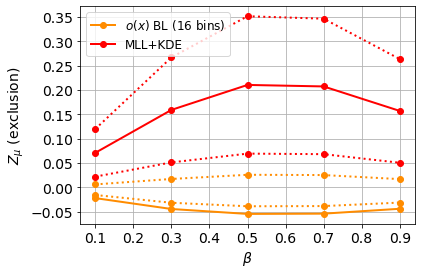

In [22]:
plt.figure()
lw = 2

plt.plot(beta, results_16bins_beta, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
plt.plot(beta, results_16bins_beta_plus, ':ok', color='darkorange', lw=lw) 
plt.plot(beta, results_16bins_beta_min, ':ok', color='darkorange', lw=lw) 

# plt.plot(beta, results_50bins_beta, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
# plt.plot(beta, results_50bins_beta_plus, ':ok', color='blue', lw=lw) 
# plt.plot(beta, results_50bins_beta_min, ':ok', color='blue', lw=lw) 

# plt.plot(beta, results_100bins_beta, '-ok', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)')
# plt.plot(beta, results_100bins_beta_plus, ':ok', color='dodgerblue', lw=lw) 
# plt.plot(beta, results_100bins_beta_min, ':ok', color='dodgerblue', lw=lw) 

plt.plot(beta, results_MLL_KDE_beta, '-ok', color='red', lw=lw, label=r'MLL+KDE')
plt.plot(beta, results_MLL_KDE_beta_plus, ':ok', color='red', lw=lw) 
plt.plot(beta, results_MLL_KDE_beta_min, ':ok', color='red', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
#plt.xscale('log')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(fontsize=12)
plt.show()